In [ ]:
# train a generative adversarial network on a one-dimensional function
import pandas as pd
from numpy import hstack
import numpy as np
from datetime import datetime
from numpy import zeros
from numpy import ones
import random
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Conv1D, LeakyReLU, Reshape, UpSampling1D
from keras.optimizers import Adam
from matplotlib import pyplot
import matplotlib.pyplot as plt 
from tqdm import tqdm
from tensorflow import keras
from keras.models import save_model, load_model
from statistics import mean, variance, pstdev
from sklearn.preprocessing import MinMaxScaler
from statistics import mean, variance, pstdev
from scipy.spatial import distance
from scipy.stats import wilcoxon
from dtaidistance import dtw
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec
import seaborn as sns
import math

In [ ]:
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LENGTH_INPUT = 288
latent_dim = 500

# Prepare training data

In [ ]:
df_591 =  pd.read_csv('/content/drive/MyDrive/Thesis/processed data/591.csv')

In [ ]:
df_591['time'] = pd.to_datetime(df_591['time'], dayfirst=True)

In [ ]:
df_591['date'] = df_591['time'].apply(lambda x: x.date())
dates = df_591['date'].unique()
glucose_591 = []
for date in dates:
  glucose_591.append(df_591[df_591['date'] == date]['glucose_value'].values)

In [ ]:
scaler = MinMaxScaler().fit(glucose_591)
glucose_591 = scaler.transform(glucose_591)

In [ ]:
glucose_591 = np.array(glucose_591)
y = ones((55, 1))

# Model Architecture

In [ ]:
# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(1, input_shape=(288,1)))
    model.add(LeakyReLU())
    
    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU())

    # Convolutional layer with LeakyReLU activation
    model.add(Conv1D(32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((2304,)))
    
    # Dense layer
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0005)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the standalone generator model
def define_generator():
    model = Sequential()
    
    # Dense layer
    model.add(Dense(3600, input_shape=(latent_dim,)))
    model.add(LeakyReLU())
    
    # Reshape layer
    model.add(Reshape((72, 50)))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    
    # Upsampling layer
    model.add(UpSampling1D(size=4))
    
    # Convolutional layer + leaky relu layer
    model.add(Conv1D(filters=32, kernel_size=2, strides=2, padding='same'))
    model.add(LeakyReLU())
    
    # Convolutional layer
    model.add(Conv1D(filters=1, kernel_size=1, padding='same'))
    
    model.compile(optimizer='adam')

    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(n):
    # generate points in the latent space from the normal distribution
    x_input = np.random.normal(size = latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
    # generate points in latent space
    x_input = generate_latent_points(n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    # create class labels
    y = zeros((n, 1))

    return X, y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=49, n_eval=100):
    d_loss_list = []
    g_loss_list = []
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)+1
    
    # manually enumerate epochs
    for i in tqdm(range(n_epochs)):
        
        # prepare real samples
        rand_index = random.sample(range(0,49), 25)
        x_real, y_real = glucose_591[rand_index], y[rand_index]
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, half_batch)
        
        # update discriminator
        d_loss_real = d_model.train_on_batch(x_real, y_real)
        d_loss_fake = d_model.train_on_batch(x_fake, y_fake)
        # average of d_loss_real and d_loss_fake
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss_list.append(d_loss)
        #print(d_loss[0])

        # prepare points in latent space as input for the generator
        #for _ in range(4):
        x_gan = generate_latent_points(n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(x_gan, y_gan)
        g_loss_list.append(g_loss)
        
       
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            generator.save_weights('/content/drive/MyDrive/Thesis/model/normal_gan/591_0.0005/generator_weights_%d.h5' %(i+1))
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288, 1)            2         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 288, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 144, 32)           160       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 32)            2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 72, 32)            0         
                                                                 
 reshape (Reshape)           (None, 2304)              0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
generator = define_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3600)              1803600   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3600)              0         
                                                                 
 reshape_1 (Reshape)         (None, 72, 50)            0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 288, 50)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 144, 32)           3232      
                                                                 
 up_sampling1d_1 (UpSampling  (None, 576, 32)          0         
 1D)                                                  

In [ ]:
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

  1%|          | 101/10000 [00:12<30:05,  5.48it/s]

99 [D loss: 0.691946, acc.: 50.00%] [G loss: 0.794131]


  2%|▏         | 201/10000 [00:21<30:52,  5.29it/s]

199 [D loss: 0.660357, acc.: 48.21%] [G loss: 0.630910]


  3%|▎         | 301/10000 [00:29<14:41, 11.00it/s]

299 [D loss: 0.644567, acc.: 78.57%] [G loss: 0.805245]


  4%|▍         | 401/10000 [00:38<14:15, 11.22it/s]

399 [D loss: 0.708141, acc.: 50.00%] [G loss: 2.069034]


  5%|▌         | 501/10000 [00:46<14:04, 11.25it/s]

499 [D loss: 0.577606, acc.: 100.00%] [G loss: 0.765582]


  6%|▌         | 600/10000 [00:55<19:13,  8.15it/s]

599 [D loss: 0.580268, acc.: 51.79%] [G loss: 1.870433]


  7%|▋         | 701/10000 [01:05<15:50,  9.79it/s]

699 [D loss: 0.356166, acc.: 100.00%] [G loss: 1.242934]


  8%|▊         | 801/10000 [01:14<14:07, 10.85it/s]

799 [D loss: 0.300479, acc.: 100.00%] [G loss: 1.362458]


  9%|▉         | 901/10000 [01:22<13:45, 11.03it/s]

899 [D loss: 0.273528, acc.: 100.00%] [G loss: 1.390226]


 10%|█         | 1001/10000 [01:31<13:33, 11.07it/s]

999 [D loss: 0.166065, acc.: 100.00%] [G loss: 1.887499]


 11%|█         | 1101/10000 [01:39<13:25, 11.05it/s]

1099 [D loss: 0.124565, acc.: 100.00%] [G loss: 2.258658]


 12%|█▏        | 1201/10000 [01:48<13:06, 11.19it/s]

1199 [D loss: 0.080012, acc.: 100.00%] [G loss: 2.503288]


 13%|█▎        | 1301/10000 [01:56<13:07, 11.04it/s]

1299 [D loss: 0.062797, acc.: 100.00%] [G loss: 3.756356]


 14%|█▍        | 1401/10000 [02:05<12:50, 11.17it/s]

1399 [D loss: 0.037130, acc.: 100.00%] [G loss: 3.471775]


 15%|█▌        | 1501/10000 [02:13<12:47, 11.07it/s]

1499 [D loss: 0.018244, acc.: 100.00%] [G loss: 3.816140]


 16%|█▌        | 1601/10000 [02:22<12:46, 10.96it/s]

1599 [D loss: 0.025116, acc.: 100.00%] [G loss: 3.847864]


 17%|█▋        | 1701/10000 [02:30<12:18, 11.24it/s]

1699 [D loss: 0.017060, acc.: 100.00%] [G loss: 4.051627]


 18%|█▊        | 1801/10000 [02:39<13:35, 10.05it/s]

1799 [D loss: 0.011837, acc.: 100.00%] [G loss: 4.341587]


 19%|█▉        | 1901/10000 [02:49<12:46, 10.57it/s]

1899 [D loss: 0.008770, acc.: 100.00%] [G loss: 4.675386]


 20%|██        | 2001/10000 [02:57<12:01, 11.08it/s]

1999 [D loss: 0.007665, acc.: 100.00%] [G loss: 4.988860]


 21%|██        | 2101/10000 [03:06<11:52, 11.09it/s]

2099 [D loss: 0.005339, acc.: 100.00%] [G loss: 4.936134]


 22%|██▏       | 2201/10000 [03:14<11:58, 10.85it/s]

2199 [D loss: 0.004982, acc.: 100.00%] [G loss: 5.309115]


 23%|██▎       | 2301/10000 [03:23<11:39, 11.01it/s]

2299 [D loss: 0.003120, acc.: 100.00%] [G loss: 5.702175]


 24%|██▍       | 2401/10000 [03:31<11:29, 11.03it/s]

2399 [D loss: 0.003268, acc.: 100.00%] [G loss: 5.553709]


 25%|██▌       | 2501/10000 [03:40<11:05, 11.27it/s]

2499 [D loss: 0.002186, acc.: 100.00%] [G loss: 5.928223]


 26%|██▌       | 2601/10000 [03:48<11:17, 10.93it/s]

2599 [D loss: 0.002917, acc.: 100.00%] [G loss: 6.211769]


 27%|██▋       | 2701/10000 [03:57<10:54, 11.15it/s]

2699 [D loss: 0.001933, acc.: 100.00%] [G loss: 6.685531]


 28%|██▊       | 2801/10000 [04:05<10:44, 11.17it/s]

2799 [D loss: 0.002557, acc.: 100.00%] [G loss: 5.648940]


 29%|██▉       | 2901/10000 [04:15<11:35, 10.20it/s]

2899 [D loss: 0.001544, acc.: 100.00%] [G loss: 6.441658]


 30%|███       | 3001/10000 [04:24<10:27, 11.15it/s]

2999 [D loss: 0.001273, acc.: 100.00%] [G loss: 6.974608]


 31%|███       | 3101/10000 [04:32<10:19, 11.14it/s]

3099 [D loss: 0.001062, acc.: 100.00%] [G loss: 7.208453]


 32%|███▏      | 3201/10000 [04:41<10:21, 10.95it/s]

3199 [D loss: 0.001138, acc.: 100.00%] [G loss: 6.446632]


 33%|███▎      | 3301/10000 [04:49<10:02, 11.11it/s]

3299 [D loss: 0.000816, acc.: 100.00%] [G loss: 7.053198]


 34%|███▍      | 3401/10000 [04:58<09:49, 11.19it/s]

3399 [D loss: 0.000757, acc.: 100.00%] [G loss: 7.618885]


 35%|███▌      | 3501/10000 [05:06<09:40, 11.20it/s]

3499 [D loss: 0.000476, acc.: 100.00%] [G loss: 7.799526]


 36%|███▌      | 3601/10000 [05:15<09:42, 10.98it/s]

3599 [D loss: 0.000559, acc.: 100.00%] [G loss: 7.079535]


 37%|███▋      | 3701/10000 [05:23<09:26, 11.11it/s]

3699 [D loss: 0.000314, acc.: 100.00%] [G loss: 7.707911]


 38%|███▊      | 3801/10000 [05:31<09:16, 11.14it/s]

3799 [D loss: 0.000380, acc.: 100.00%] [G loss: 8.096632]


 39%|███▉      | 3901/10000 [05:40<09:14, 11.00it/s]

3899 [D loss: 0.000292, acc.: 100.00%] [G loss: 8.296673]


 40%|████      | 4001/10000 [05:49<10:04,  9.93it/s]

3999 [D loss: 0.000273, acc.: 100.00%] [G loss: 8.158642]


 41%|████      | 4101/10000 [05:58<08:41, 11.30it/s]

4099 [D loss: 0.000176, acc.: 100.00%] [G loss: 8.208090]


 42%|████▏     | 4201/10000 [06:07<08:44, 11.05it/s]

4199 [D loss: 0.000213, acc.: 100.00%] [G loss: 8.684859]


 43%|████▎     | 4301/10000 [06:15<08:34, 11.09it/s]

4299 [D loss: 0.000136, acc.: 100.00%] [G loss: 8.868317]


 44%|████▍     | 4401/10000 [06:24<08:14, 11.32it/s]

4399 [D loss: 0.000173, acc.: 100.00%] [G loss: 8.604692]


 45%|████▌     | 4501/10000 [06:32<08:10, 11.21it/s]

4499 [D loss: 0.000130, acc.: 100.00%] [G loss: 8.640985]


 46%|████▌     | 4601/10000 [06:41<07:58, 11.27it/s]

4599 [D loss: 0.000112, acc.: 100.00%] [G loss: 9.276571]


 47%|████▋     | 4701/10000 [06:49<07:58, 11.07it/s]

4699 [D loss: 0.000092, acc.: 100.00%] [G loss: 9.324582]


 48%|████▊     | 4801/10000 [06:58<07:53, 10.97it/s]

4799 [D loss: 0.000099, acc.: 100.00%] [G loss: 8.822464]


 49%|████▉     | 4901/10000 [07:06<07:40, 11.06it/s]

4899 [D loss: 0.000094, acc.: 100.00%] [G loss: 9.735538]


 50%|█████     | 5001/10000 [07:15<07:35, 10.98it/s]

4999 [D loss: 0.000053, acc.: 100.00%] [G loss: 9.897331]


 51%|█████     | 5101/10000 [07:24<08:04, 10.11it/s]

5099 [D loss: 0.000067, acc.: 100.00%] [G loss: 9.820297]


 52%|█████▏    | 5201/10000 [07:33<07:06, 11.25it/s]

5199 [D loss: 0.000055, acc.: 100.00%] [G loss: 9.404983]


 53%|█████▎    | 5301/10000 [07:42<06:56, 11.29it/s]

5299 [D loss: 0.000042, acc.: 100.00%] [G loss: 10.172142]


 54%|█████▍    | 5401/10000 [07:50<06:54, 11.10it/s]

5399 [D loss: 0.000048, acc.: 100.00%] [G loss: 10.267229]


 55%|█████▌    | 5501/10000 [07:58<06:42, 11.18it/s]

5499 [D loss: 0.000042, acc.: 100.00%] [G loss: 10.347826]


 56%|█████▌    | 5601/10000 [08:07<06:36, 11.08it/s]

5599 [D loss: 0.000032, acc.: 100.00%] [G loss: 9.964771]


 57%|█████▋    | 5701/10000 [08:15<06:28, 11.07it/s]

5699 [D loss: 0.000033, acc.: 100.00%] [G loss: 10.704456]


 58%|█████▊    | 5801/10000 [08:24<06:11, 11.29it/s]

5799 [D loss: 0.000028, acc.: 100.00%] [G loss: 10.905631]


 59%|█████▉    | 5901/10000 [08:32<06:11, 11.03it/s]

5899 [D loss: 0.000023, acc.: 100.00%] [G loss: 10.744181]


 60%|██████    | 6001/10000 [08:41<06:10, 10.81it/s]

5999 [D loss: 0.000018, acc.: 100.00%] [G loss: 10.605761]


 61%|██████    | 6102/10000 [08:50<07:05,  9.15it/s]

6099 [D loss: 0.000014, acc.: 100.00%] [G loss: 11.109905]


 62%|██████▏   | 6201/10000 [08:59<06:01, 10.51it/s]

6199 [D loss: 0.000015, acc.: 100.00%] [G loss: 11.276000]


 63%|██████▎   | 6301/10000 [09:08<05:33, 11.09it/s]

6299 [D loss: 0.000014, acc.: 100.00%] [G loss: 11.127888]


 64%|██████▍   | 6401/10000 [09:16<05:27, 10.99it/s]

6399 [D loss: 0.000011, acc.: 100.00%] [G loss: 11.114843]


 65%|██████▌   | 6501/10000 [09:25<05:12, 11.21it/s]

6499 [D loss: 0.000012, acc.: 100.00%] [G loss: 11.558324]


 66%|██████▌   | 6601/10000 [09:33<05:07, 11.04it/s]

6599 [D loss: 0.000008, acc.: 100.00%] [G loss: 11.915704]


 67%|██████▋   | 6701/10000 [09:42<04:55, 11.18it/s]

6699 [D loss: 0.000007, acc.: 100.00%] [G loss: 11.461511]


 68%|██████▊   | 6801/10000 [09:50<04:50, 11.00it/s]

6799 [D loss: 0.000007, acc.: 100.00%] [G loss: 11.663183]


 69%|██████▉   | 6901/10000 [09:59<04:35, 11.27it/s]

6899 [D loss: 0.000008, acc.: 100.00%] [G loss: 12.115795]


 70%|███████   | 7001/10000 [10:07<04:30, 11.11it/s]

6999 [D loss: 0.000005, acc.: 100.00%] [G loss: 12.267390]


 71%|███████   | 7101/10000 [10:16<04:20, 11.15it/s]

7099 [D loss: 0.000006, acc.: 100.00%] [G loss: 11.872558]


 72%|███████▏  | 7201/10000 [10:24<04:09, 11.23it/s]

7199 [D loss: 0.000004, acc.: 100.00%] [G loss: 12.086695]


 73%|███████▎  | 7302/10000 [10:34<04:24, 10.19it/s]

7299 [D loss: 0.000004, acc.: 100.00%] [G loss: 12.376455]


 74%|███████▍  | 7402/10000 [10:43<03:52, 11.20it/s]

7399 [D loss: 0.000004, acc.: 100.00%] [G loss: 12.617185]


 75%|███████▌  | 7502/10000 [10:51<03:37, 11.49it/s]

7499 [D loss: 0.000003, acc.: 100.00%] [G loss: 12.736846]


 76%|███████▌  | 7602/10000 [11:00<03:31, 11.34it/s]

7599 [D loss: 0.000003, acc.: 100.00%] [G loss: 12.488972]


 77%|███████▋  | 7702/10000 [11:08<03:25, 11.16it/s]

7699 [D loss: 0.000003, acc.: 100.00%] [G loss: 12.729485]


 78%|███████▊  | 7802/10000 [11:16<03:13, 11.34it/s]

7799 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.029915]


 79%|███████▉  | 7902/10000 [11:25<03:05, 11.28it/s]

7899 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.124475]


 80%|████████  | 8002/10000 [11:33<03:01, 11.01it/s]

7999 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.310800]


 81%|████████  | 8102/10000 [11:42<02:45, 11.44it/s]

8099 [D loss: 0.000002, acc.: 100.00%] [G loss: 13.508264]


 82%|████████▏ | 8202/10000 [11:50<02:39, 11.28it/s]

8199 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.532874]


 83%|████████▎ | 8302/10000 [11:59<02:49, 10.04it/s]

8299 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.678838]


 84%|████████▍ | 8401/10000 [12:09<02:33, 10.40it/s]

8399 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.712255]


 85%|████████▌ | 8501/10000 [12:17<02:16, 11.01it/s]

8499 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.768019]


 86%|████████▌ | 8601/10000 [12:26<02:05, 11.18it/s]

8599 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.824007]


 87%|████████▋ | 8701/10000 [12:34<01:56, 11.19it/s]

8699 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.905130]


 88%|████████▊ | 8801/10000 [12:42<01:48, 11.10it/s]

8799 [D loss: 0.000001, acc.: 100.00%] [G loss: 13.812802]


 89%|████████▉ | 8901/10000 [12:51<01:41, 10.85it/s]

8899 [D loss: 0.000001, acc.: 100.00%] [G loss: 14.214559]


 90%|█████████ | 9001/10000 [12:59<01:30, 10.99it/s]

8999 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.342158]


 91%|█████████ | 9101/10000 [13:08<01:19, 11.29it/s]

9099 [D loss: 0.000001, acc.: 100.00%] [G loss: 14.474749]


 92%|█████████▏| 9201/10000 [13:16<01:11, 11.21it/s]

9199 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.610629]


 93%|█████████▎| 9301/10000 [13:25<01:02, 11.26it/s]

9299 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.778719]


 94%|█████████▍| 9401/10000 [13:34<00:59, 10.02it/s]

9399 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.947834]


 95%|█████████▌| 9501/10000 [13:43<00:44, 11.16it/s]

9499 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.977457]


 96%|█████████▌| 9601/10000 [13:51<00:34, 11.42it/s]

9599 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.067617]


 97%|█████████▋| 9701/10000 [14:00<00:27, 11.01it/s]

9699 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.966703]


 98%|█████████▊| 9801/10000 [14:08<00:18, 11.00it/s]

9799 [D loss: 0.000000, acc.: 100.00%] [G loss: 14.895344]


 99%|█████████▉| 9901/10000 [14:17<00:08, 11.44it/s]

9899 [D loss: 0.000000, acc.: 100.00%] [G loss: 15.359177]


100%|██████████| 10000/10000 [14:25<00:00, 11.55it/s]

9999 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.226418]


# Evaluation

In [ ]:
mean_list = []
std_list = []
hyper_list = []
tir_list = []
l1_list = []
l2_list = []
for i in tqdm(range(1, 101)):
  generator.load_weights('/content/drive/MyDrive/Thesis/model/normal_gan/591_0.0005/generator_weights_' + str(i*100) + '.h5')
  for j in range(6):
    sub_mean = []
    sub_std = []
    hyper = []
    tir = []
    l1 = []
    l2 = []

    synth, _ = generate_fake_samples(generator, 49)
    synth = synth.reshape(49,288)

    synth_data = scaler.inverse_transform(synth)

    sub_mean.append(mean(synth_data.flatten()))
    sub_std.append(pstdev(synth_data.flatten().tolist()))

    extracted_hyper = np.extract((synth_data >= 180), synth_data)
    hyper.append(extracted_hyper.shape[0] / (288*49))
    extracted_tir = np.extract(((synth_data < 180) & (synth_data >= 70)), synth_data)
    tir.append(extracted_tir.shape[0] / (288*49))
    extracted_l1 = np.extract(((synth_data < 70) & (synth_data >= 54)), synth_data)
    l1.append(extracted_l1.shape[0] / (288*49))
    extracted_l2 = np.extract((synth_data < 54), synth_data)
    l2.append(extracted_l2.shape[0] / (288*49))

  mean_list.append(mean(sub_mean))
  std_list.append(mean(sub_std))
  hyper_list.append(mean(hyper))
  tir_list.append(mean(tir))
  l1_list.append(mean(l1))
  l2_list.append(mean(l2))

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


In [ ]:
df_591_result = pd.DataFrame(list(zip(hyper_list, tir_list, l1_list, l2_list, mean_list, std_list)), columns = ['Hyper', 'TIR', 'L1 Hypo', 'L2 Hypo', 'Mean', 'SD'])

In [ ]:
df_591_result.to_csv('/content/drive/MyDrive/Thesis/model/normal_gan/591_0.0005/evaluation.csv')

In [ ]:
df_591_result[:50]

,Hyper,TIR,L1 Hypo,L2 Hypo,Mean,SD
0,0.124008,0.811224,0.037628,0.027140,131.220963,43.585736
1,0.145479,0.851332,0.003047,0.000142,147.834106,31.227234
2,0.192744,0.807256,0.000000,0.000000,161.835281,22.189109
3,0.985048,0.014952,0.000000,0.000000,317.202209,70.112471
4,0.000000,0.999858,0.000142,0.000000,118.567894,15.177212
5,0.961522,0.038478,0.000000,0.000000,288.114594,67.104569
6,0.010984,0.989016,0.000000,0.000000,149.703308,13.238741
7,0.078940,0.920989,0.000071,0.000000,161.184265,13.903979
8,0.016582,0.983418,0.000000,0.000000,148.696899,13.779622
9,0.004748,0.994118,0.000283,0.000850,150.493881,13.551816


# The comparsion between the results of normal GAN and TimeGAN

In [ ]:
generator.load_weights('/content/drive/MyDrive/Thesis/model/normal_gan/591_0.0005/generator_weights_2900.h5')
synth_norm, _ = generate_fake_samples(generator, 49)
synth_norm=synth_norm.reshape(49,288)
synth_timegan = np.load("/content/drive/MyDrive/Thesis/best model/timegan_591_128/synthetic_data_nonorm.npy")

In [ ]:
# unnormalized synthetic and real data
synth_normgan_norm = synth_norm
synth_timegan_norm = np.load("/content/drive/MyDrive/Thesis/best model/timegan_591_128/synthetic_data.npy")
synth_normgan_nonnorm = scaler.inverse_transform(synth_norm)
synth_timegan_nonnorm = synth_timegan
real_ori = scaler.inverse_transform(glucose_591)
real_norm = glucose_591

SVM

In [ ]:
x = real_ori.tolist()
y = my_list = [1]*49
x_timegan = [synth_timegan_nonnorm[7][0][i][:,0].tolist() for i in range(49)]
x_normgan = synth_normgan_nonnorm
y_timegan = [0]*49

x.extend(x_timegan)
y.extend(y_timegan)

In [ ]:
import random

numbers = list(range(98))

num_selected_70 = random.sample(numbers, int(0.7*len(numbers)))

num_selected_30 = list(set(numbers) - set(num_selected_70))

print("training index：", num_selected_70)
print("test index：", num_selected_30)

training index： [29, 59, 82, 60, 83, 28, 32, 43, 26, 12, 18, 4, 56, 90, 61, 5, 74, 57, 31, 1, 91, 40, 30, 21, 47, 76, 77, 15, 45, 62, 85, 72, 0, 2, 84, 27, 49, 70, 75, 55, 22, 48, 92, 64, 10, 16, 36, 35, 46, 9, 25, 58, 94, 34, 53, 11, 8, 63, 38, 88, 39, 81, 14, 33, 87, 65, 17, 69]
test index： [3, 6, 7, 13, 19, 20, 23, 24, 37, 41, 42, 44, 50, 51, 52, 54, 66, 67, 68, 71, 73, 78, 79, 80, 86, 89, 93, 95, 96, 97]


In [ ]:
training_x = [x[num_selected_70[i]] for i in range(len(num_selected_70))]
test_x = [x[num_selected_30[i]] for i in range(len(num_selected_30))]
training_y = [y[num_selected_70[i]] for i in range(len(num_selected_70))]
test_y = [y[num_selected_30[i]] for i in range(len(num_selected_30))]

In [ ]:
from sklearn import svm, metrics
classifier = svm.SVC()

# Train the classifier on the training data
classifier.fit(training_x, training_y)

# Predict the labels of the test data
y_pred = classifier.predict(test_x)

# Calculate the accuracy and F1 score of the classifier
accuracy = metrics.accuracy_score(test_y, y_pred)
f1_score = metrics.f1_score(test_y, y_pred, average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("F1 score:", f1_score)

Accuracy: 0.8333333333333334
F1 score: 0.827838827838828


RNN for prediction

In [ ]:
#Split training and test set
n_events = len(real_ori)

idx = np.arange(n_events)
n_train = int(.8*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
# get training and test data (use past 6h data to predict next 30min)
pre_len = 6 # 5*6=30 -> 30min
train_len = 72 #12*6 -> 6h

train_real_x = []
train_real_y = []
train_syn_norm_x = []
train_syn_norm_y = []
train_syn_time_x = []
train_syn_time_y = []

for i in range(len(train_idx)):
  for j in range(288-(pre_len+train_len)+1):
    train_real_x.append(glucose_591[train_idx[i], j:(j+train_len)])
    train_real_y.append(glucose_591[train_idx[i], (j+train_len):(j+train_len+pre_len)])

    train_syn_norm_x.append(synth_normgan_norm[train_idx[i], j:(j+train_len)])
    train_syn_norm_y.append(synth_normgan_norm[train_idx[i], (j+train_len):(j+train_len+pre_len)])

    train_syn_time_x.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(49)])[train_idx[i], j:(j+train_len)])
    train_syn_time_y.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(49)])[train_idx[i], (j+train_len):(j+train_len+pre_len)])

test_real_x = []
test_real_y = []
test_syn_norm_x = []
test_syn_norm_y = []
test_syn_time_x = []
test_syn_time_y = []

for i in range(len(test_idx)):
  for j in range(288-(pre_len+train_len)+1):
    test_real_x.append(glucose_591[test_idx[i], j:(j+train_len)])
    test_real_y.append(glucose_591[test_idx[i], (j+train_len):(j+train_len+pre_len)])

    test_syn_norm_x.append(synth_normgan_norm[test_idx[i], j:(j+train_len)])
    test_syn_norm_y.append(synth_normgan_norm[test_idx[i], (j+train_len):(j+train_len+pre_len)])

    test_syn_time_x.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(49)])[test_idx[i], j:(j+train_len)])
    test_syn_time_y.append(np.array([synth_timegan_norm[7][0][n][:,0] for n in range(49)])[test_idx[i], (j+train_len):(j+train_len+pre_len)])

train_real_x = np.array(train_real_x)
train_real_y = np.array(train_real_y)
train_syn_norm_x = np.array(train_syn_norm_x)
train_syn_norm_y = np.array(train_syn_norm_y)
train_syn_time_x = np.array(train_syn_time_x)
train_syn_time_y = np.array(train_syn_time_y)


test_real_x = np.array(test_real_x)
test_real_y = np.array(test_real_y)
test_syn_norm_x = np.array(test_syn_norm_x)
test_syn_norm_y = np.array(test_syn_norm_y)
test_syn_time_x = np.array(test_syn_time_x)
test_syn_time_y = np.array(test_syn_time_y)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error

tf.random.set_seed(7)
#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units, input_shape=(72,1),
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

real_train = ts_real.fit(x=train_real_x,
                          y=train_real_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
65/65 [==============================] - 4s 12ms/step - loss: 0.1624 - val_loss: 0.1140
Epoch 2/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0991 - val_loss: 0.0855
Epoch 3/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0836 - val_loss: 0.0789
Epoch 4/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0787 - val_loss: 0.0768
Epoch 5/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0755 - val_loss: 0.0769
Epoch 6/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0736 - val_loss: 0.0716
Epoch 7/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0726 - val_loss: 0.0731
Epoch 8/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0709 - val_loss: 0.0691
Epoch 9/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0697 - val_loss: 0.0709
Epoch 10/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0690 - val_loss: 0.0682
Epoch 11

In [ ]:
# TRTR results
real_predictions = ts_real.predict(test_real_x)
r2_real = r2_score(test_real_y, real_predictions)
mae_real = mean_absolute_error(test_real_y, real_predictions)
mrle_real = mean_squared_log_error(test_real_y, real_predictions)
print(r2_real)
print(mae_real)
print(mrle_real)

66/66 [==============================] - 0s 2ms/step
0.8549357798904738
0.06012895560070416
0.004032207505230669


In [ ]:
#Training the model with the synthetic data from normal GAN
ts_norm_syn = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

norm_syn_train = ts_norm_syn.fit(x=train_syn_norm_x,
                          y=train_syn_norm_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
65/65 [==============================] - 3s 12ms/step - loss: 0.1479 - val_loss: 0.1629
Epoch 2/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0835 - val_loss: 0.1015
Epoch 3/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0688 - val_loss: 0.0912
Epoch 4/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0639 - val_loss: 0.0841
Epoch 5/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.0806
Epoch 6/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0597 - val_loss: 0.0783
Epoch 7/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0587 - val_loss: 0.0770
Epoch 8/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0570 - val_loss: 0.0759
Epoch 9/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0561 - val_loss: 0.0764
Epoch 10/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0554 - val_loss: 0.0764
Epoch 11

In [ ]:
# TSTR results from normal GAN
syn_norm_predictions = ts_norm_syn.predict(test_real_x)
r2_syn_norm = r2_score(test_real_y, syn_norm_predictions)
mae_syn_norm = mean_absolute_error(test_real_y, syn_norm_predictions)
mrle_syn_norm = mean_squared_log_error(test_real_y, syn_norm_predictions)
print(r2_syn_norm)
print(mae_syn_norm)
print(mrle_syn_norm)

66/66 [==============================] - 0s 2ms/step
0.7910057136947538
0.07766508096440676
0.0060364736203753514


In [ ]:
#Training the model with the synthetic data from TimeGAN
ts_time_syn = RNN_regression(72)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

time_syn_train = ts_time_syn.fit(x=train_syn_time_x,
                          y=train_syn_time_y,
                          validation_data=(test_real_x, test_real_y),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
65/65 [==============================] - 3s 12ms/step - loss: 0.1549 - val_loss: 0.1915
Epoch 2/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0936 - val_loss: 0.1139
Epoch 3/200
65/65 [==============================] - 0s 5ms/step - loss: 0.0464 - val_loss: 0.0946
Epoch 4/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0356 - val_loss: 0.0932
Epoch 5/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0319 - val_loss: 0.0870
Epoch 6/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0296 - val_loss: 0.0855
Epoch 7/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0851
Epoch 8/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0853
Epoch 9/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0255 - val_loss: 0.0843
Epoch 10/200
65/65 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0842
Epoch 11

In [ ]:
# TSTR results from TimeGAN
syn_time_predictions = ts_time_syn.predict(test_real_x)
r2_syn_time = r2_score(test_real_y, syn_time_predictions)
mae_syn_time = mean_absolute_error(test_real_y, syn_time_predictions)
mrle_syn_time = mean_squared_log_error(test_real_y, syn_time_predictions)
print(r2_syn_time)
print(mae_syn_time)
print(mrle_syn_time)

66/66 [==============================] - 0s 2ms/step
0.7867301222886076
0.07638182573847328
0.005834738560644492


visualization of real and synthetic data

<Axes: title={'center': 'blood glucose (Patient 591)'}>

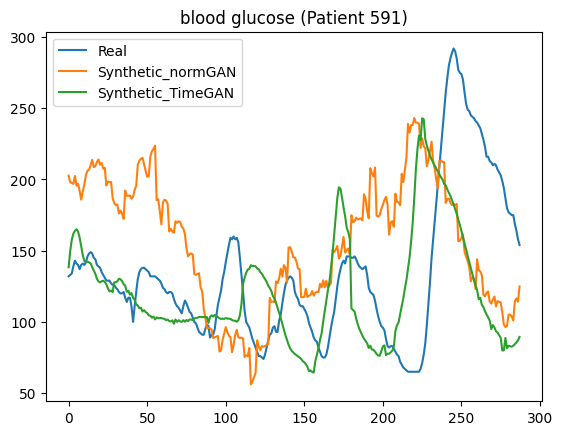

In [ ]:
cols = 'blood glucose (Patient 591)'

df = pd.DataFrame({'Real': real_ori[10], 'Synthetic_normGAN': synth_normgan_nonnorm[10], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][10][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

<Axes: title={'center': 'blood glucose (Patient 591)'}>

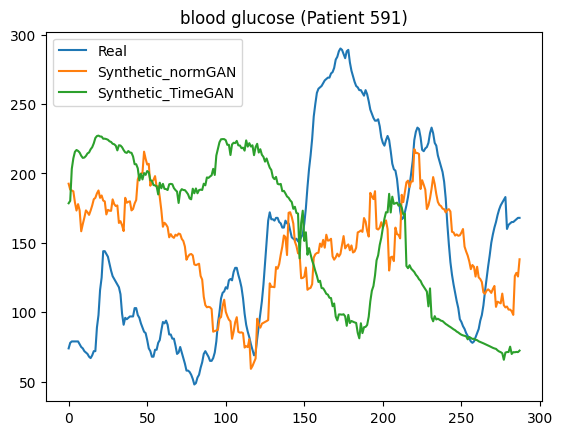

In [ ]:
cols = 'blood glucose (Patient 591)'

df = pd.DataFrame({'Real': real_ori[25], 'Synthetic_normGAN': synth_normgan_nonnorm[25], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][25][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

<Axes: title={'center': 'blood glucose (Patient 591)'}>

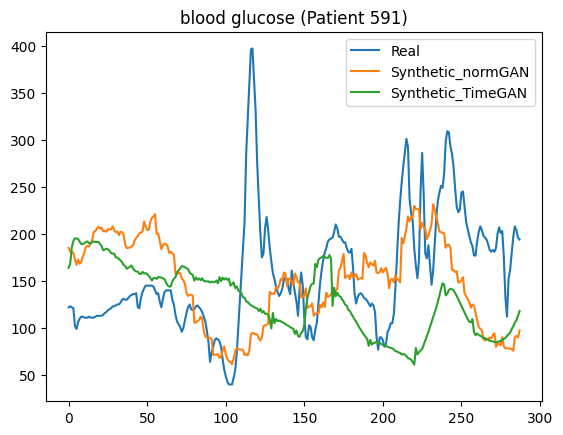

In [ ]:
cols = 'blood glucose (Patient 591)'

df = pd.DataFrame({'Real': real_ori[33], 'Synthetic_normGAN': synth_normgan_nonnorm[33], 'Synthetic_TimeGAN': synth_timegan_nonnorm[7][0][33][:, 0]})
df.plot(title = cols,
        secondary_y='Synthetic data', style=['-'])

JS distance and DTW

In [ ]:
# Wilcoxon test
res_normgan = wilcoxon(synth_normgan_nonnorm, real_ori, alternative = 'two-sided', zero_method='wilcox')
res_timegan = wilcoxon([synth_timegan_nonnorm[7][0][i][:,0] for i in range(49)], real_ori, alternative = 'two-sided', zero_method='wilcox')
print('Normal GAN Wiloxon test: {}'.format(mean(res_normgan.pvalue.flatten())))
print('TimeGAN Wiloxon test: {}'.format(mean(res_timegan.pvalue.flatten())))

# JS distance
dis_normgan = distance.jensenshannon(synth_normgan_nonnorm, real_ori, axis=1)
dis_timegan = distance.jensenshannon([synth_timegan_nonnorm[7][0][i][:,0] for i in range(49)], real_ori, axis=1)
print('Normal JS distance: {}'.format(mean(dis_normgan.flatten())))
print('TimeGAN JS distance: {}'.format(mean(dis_timegan.flatten())))

# Eculidean distance
e_dis_norm = [math.dist(synth_normgan_norm[i], glucose_591[i]) for i in range(len(real_ori))]
e_dis_time = [math.dist([synth_timegan_norm[7][0][j][:,0] for j in range(49)][i], glucose_591[i]) for i in range(len(real_ori))]
print('Normal Eculidean distance: {}'.format(mean(e_dis_norm)))
print('TimeGAN Eculidean distance: {}'.format(mean(e_dis_time)))

Normal GAN Wiloxon test: 0.13854888782449534
TimeGAN Wiloxon test: 0.34831827370385166
Normal JS distance: 0.13728270787287275
TimeGAN JS distance: 0.15772638982638804
Normal Eculidean distance: 4.748279194161136
TimeGAN Eculidean distance: 4.993954659251352


In [ ]:
# DTW
dtw_normgan = []
dtw_timegan = []
for i in range(len(real_ori)):
  dtw_normgan.append(dtw.distance(synth_normgan_norm[i], glucose_591[i]))
  dtw_timegan.append(dtw.distance([synth_timegan_norm[7][0][i][:,0] for i in range(49)][i], glucose_591[i]))

print('Normal DTW distance: {}'.format(mean(dtw_normgan)))
print('TimeGAN DTW distance: {}'.format(mean(dtw_timegan)))

Normal DTW distance: 2.488818974336171
TimeGAN DTW distance: 2.86507186286997


visualization of PCA and t-SNE

In [ ]:
sample_size = 49
idx = np.random.permutation(len(real_ori))[:sample_size]

real_sample = np.asarray(real_ori)[idx]

synthetic_sample_norm = np.asarray(synth_normgan_nonnorm)[idx]

synth_data_reduced = real_sample.reshape(-1, 288)
patient_data_reduced_norm = np.asarray(synthetic_sample_norm).reshape(-1,288)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(synth_data_reduced)

pca_real = pd.DataFrame(pca.transform(synth_data_reduced))
pca_synth_norm = pd.DataFrame(pca.transform(patient_data_reduced_norm))

data_reduced = np.concatenate((synth_data_reduced, patient_data_reduced_norm), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

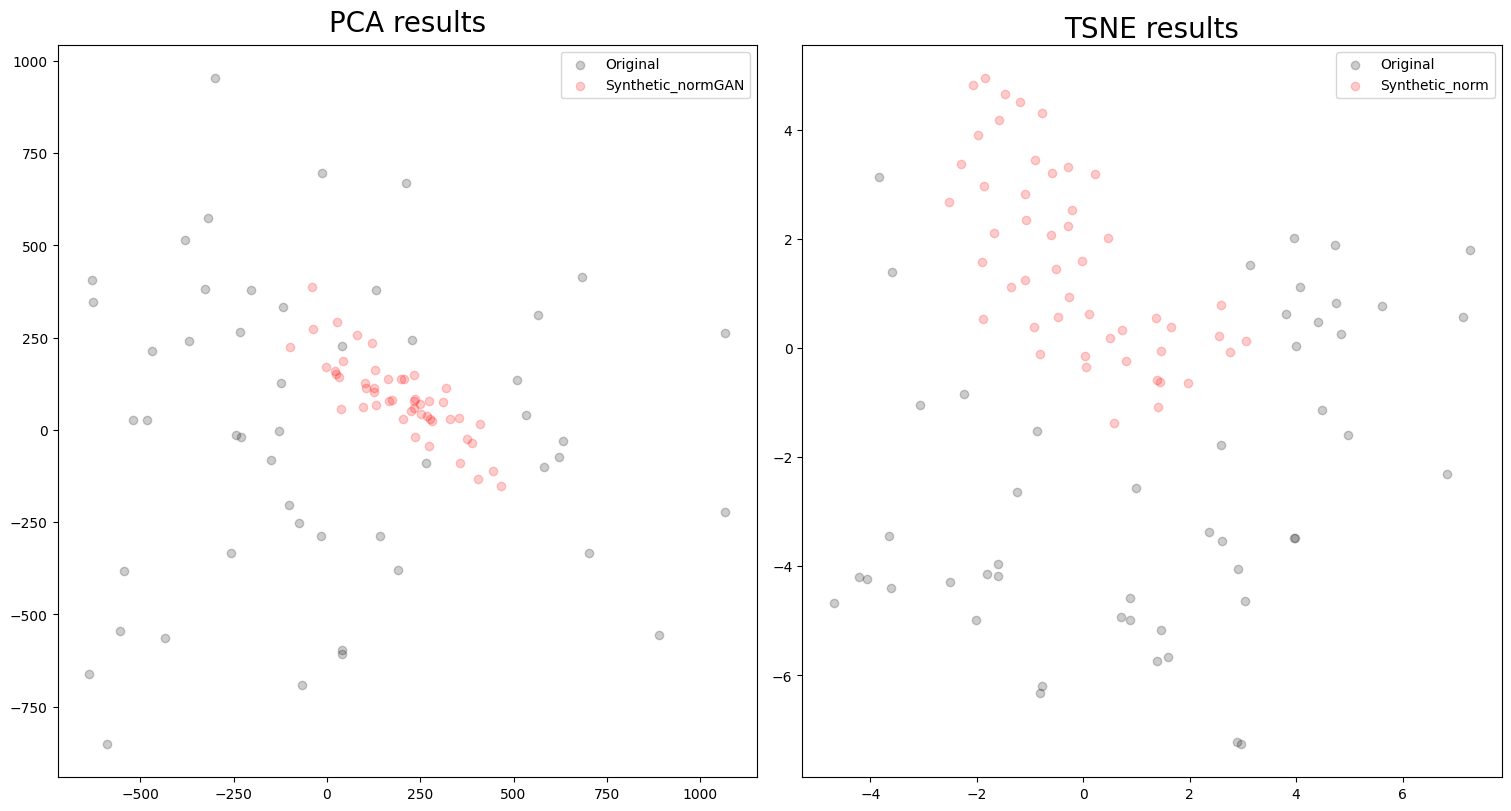

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15,8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth_norm.iloc[:,0], pca_synth_norm.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic_normGAN')

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic_norm')

ax2.legend()

#fig.suptitle('Validating synthetic vs real data diversity and distributions',
#             fontsize=16)

In [ ]:
sample_size = 49
idx = np.random.permutation(len(real_ori))[:sample_size]

real_sample = np.asarray(real_ori)[idx]

synthetic_sample_timegan = np.asarray([synth_timegan_nonnorm[7][0][i][:,0] for i in range(55)])[idx]

synth_data_reduced = real_sample.reshape(-1, 288)
patient_data_reduced_timegan = np.asarray(synthetic_sample_timegan).reshape(-1,288)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(synth_data_reduced)

pca_real = pd.DataFrame(pca.transform(synth_data_reduced))
pca_synth_timegan = pd.DataFrame(pca.transform(patient_data_reduced_timegan))

data_reduced = np.concatenate((synth_data_reduced, patient_data_reduced_timegan), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

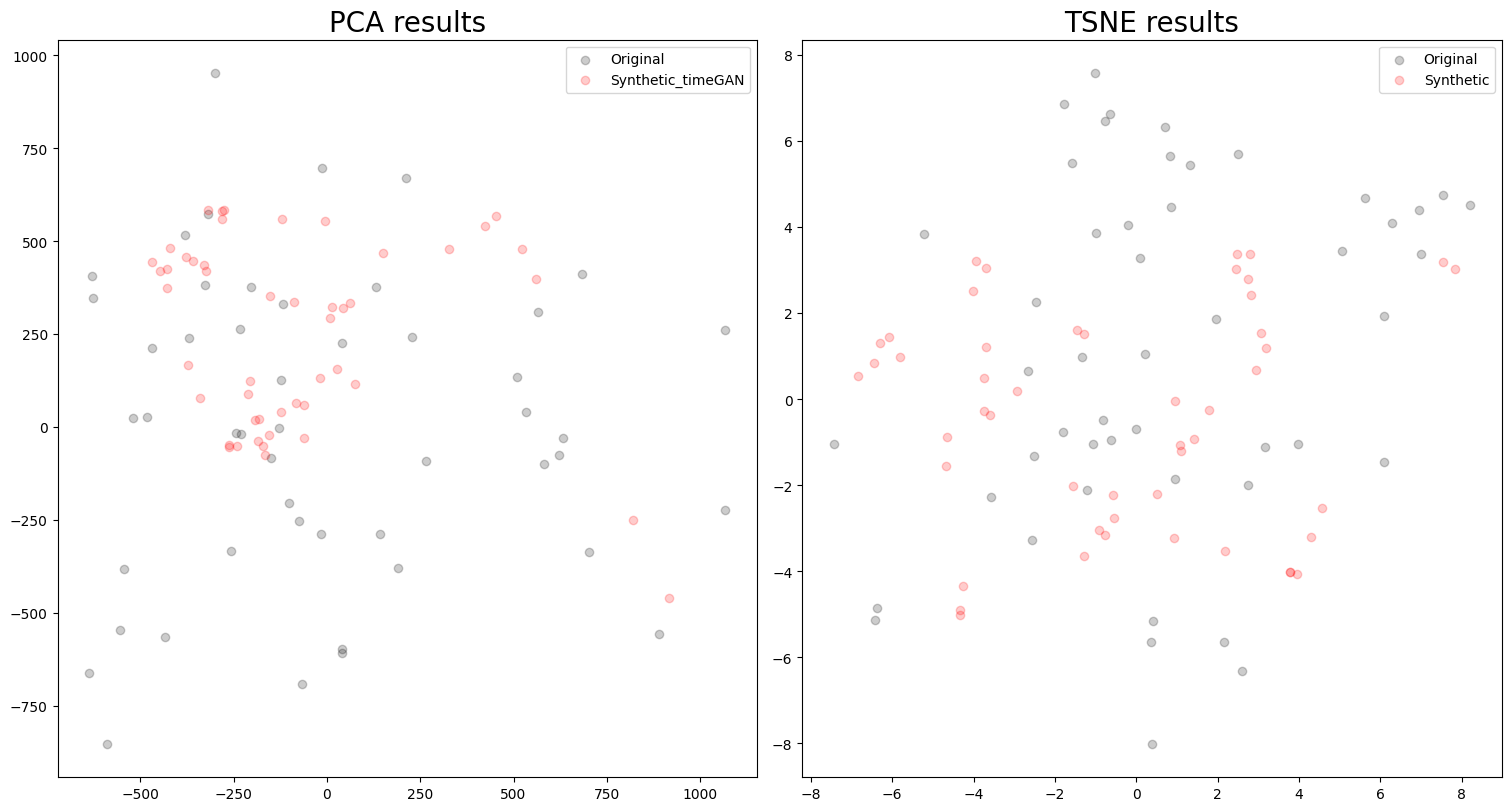

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15,8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth_timegan.iloc[:,0], pca_synth_timegan.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic_timeGAN')

ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

#fig.suptitle('Validating synthetic vs real data diversity and distributions',
#             fontsize=16)